In [35]:
import os
import sys
import tensorflow as tf

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ml.models.three_d import voxnet_no_gen
from ml.models.three_d import c3d

In [36]:
import csv
import numpy as np
import random
from keras.preprocessing.image import ImageDataGenerator
from google.cloud import storage
from etl.lib import cloud_management

In [37]:
BLACKLIST = []
        
# Delete all content in /home/amy/data/chunkss
filelist = [f for f in os.listdir('/home/amy/data/chunks/')]
for f in filelist:
    os.remove(os.path.join('/home/amy/data/chunks/', f))

# Access Google Cloud Storage
gcs_client = storage.Client.from_service_account_json(
    '/home/amy/credentials/client_secret.json'
)
bucket = gcs_client.get_bucket('elvos')

# Get label data from Google Cloud Storage
blob = storage.Blob('no_aug_annotated_labels.csv', bucket)
blob.download_to_filename('/home/amy/data/no_aug_annotated_labels.csv')
prelim_label_data = {}
with open('/home/amy/data/no_aug_annotated_labels.csv', 'r') as pos_file:
    reader = csv.reader(pos_file, delimiter=',')
    for row in reader:
        if row[1] != 'Unnamed: 0.1':
            #print
            prelim_label_data[row[1]] = int(row[2])
            #print(row[1])

In [38]:
# Get all of the positives from the label data
positive_label_data = {}
#print('getting positive labels')
for id_, label in list(prelim_label_data.items()):
    if label == 1:
        positive_label_data[id_] = label
        #print(id_)
#print(len(positive_label_data))

In [39]:
#Get 600 random negatives from the label data to feed into our generator
negative_counter = 0
negative_label_data = {}
#print(f"getting {len(list(positive_label_data.keys()))} random negative labels")
while negative_counter < 550:
    id_, label = random.choice(list(prelim_label_data.items()))
    if label == 0:
        negative_label_data[id_] = label
        del prelim_label_data[id_]
        negative_counter += 1

In [40]:
chunks = []
labels = []

In [41]:
i = 1
for id_, label in list(negative_label_data.items()):
    #print(i, 'chunk_data/normal/negative/' + id_ + '.npy')
    blob = bucket.get_blob('chunk_data/normal/negative/' + id_ + '.npy')
    arr = cloud_management.download_array(blob)
    if arr.shape == (32, 32, 32):
        arr = np.expand_dims(arr, axis=-1)
        chunks.append(arr)
        labels.append(label)
        i += 1

In [42]:
i = 1
for id_, label in list(positive_label_data.items()):
    #print(i, 'chunk_data/normal/positive_no_aug/' + id_  + '.npy')
    blob = bucket.get_blob('chunk_data/normal/positive_no_aug/' + id_ + '.npy')
    #print(blob)
    arr = cloud_management.download_array(blob)
    if arr.shape == (32, 32, 32):
        arr = np.expand_dims(arr, axis=-1)
        chunks.append(arr)
        labels.append(label)
        i += 1

In [43]:
tmp = list(zip(chunks, labels))
random.shuffle(tmp)
chunks, labels = zip(*tmp)

# Split based on validation
# print('splitting based on validation split')
X_train = np.asarray(chunks[int(len(chunks) * 0.1):])
y_train = np.asarray(labels[int(len(labels) * 0.1):])

X_val = np.asarray(chunks[:int(len(chunks) * 0.1)])
y_val = np.asarray(labels[:int(len(labels) * 0.1)])

In [44]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [45]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy, binary_crossentropy
from keras.callbacks import ModelCheckpoint


In [46]:
from keras.optimizers import SGD
from keras import metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint

LEARN_RATE = 1e-5

In [47]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(859, 32, 32, 32, 1) (859,)
(95, 32, 32, 32, 1) (95,)


In [48]:
def true_positives(y_true, y_pred):
    return K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))


def false_negatives(y_true, y_pred):
    return K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))


def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [49]:
metrics.true_positives = true_positives
metrics.false_negtives = false_negatives
metrics.sensitivity = sensitivity
metrics.specificity = specificity

In [50]:
model = c3d.C3DBuilder.build()
model.compile(optimizer=SGD(lr=LEARN_RATE, momentum=0.9, nesterov=True),
              loss={"out_class": "binary_crossentropy"},
#               loss='binary_crossentropy'
              metrics={"out_class": [metrics.binary_accuracy,
                                     metrics.binary_crossentropy,
                                     true_positives,
                                     false_negatives,
                                     sensitivity,
                                     specificity]})


____________________________________________________________________________________________________________________________________________
Layer (type)                                                   Output Shape                                            Param #              
input_1 (InputLayer)                                           (None, 32, 32, 32, 1)                                   0                    
____________________________________________________________________________________________________________________________________________
average_pooling3d_2 (AveragePooling3D)                         (None, 16, 32, 32, 1)                                   0                    
____________________________________________________________________________________________________________________________________________
conv1 (Conv3D)                                                 (None, 16, 32, 32, 64)                                  1792                 
_____________

/home/amy/elvo-analysis/ml/models/three_d/c3d.py:21: UserWarning: Update your `AveragePooling3D` call to the Keras 2 API: `AveragePooling3D(pool_size=(2, 1, 1), strides=(2, 1, 1), padding="same")`
  strides=(2, 1, 1), border_mode="same")(x)
/home/amy/elvo-analysis/ml/models/three_d/c3d.py:24: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", strides=(1, 1, 1), padding="same")`
  subsample=(1, 1, 1))(x)
/home/amy/elvo-analysis/ml/models/three_d/c3d.py:27: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  name='pool1')(x)
/home/amy/elvo-analysis/ml/models/three_d/c3d.py:32: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", strides=(1, 1, 1), padding="same")`
  subsample=(1, 1, 1))(x)
/home/amy/elvo-analysis/ml/models/three_d/c3d.py:34: UserWarning: Update yo

In [51]:
mc_callback = ModelCheckpoint(filepath='tmp/c3d_weights.hdf5', verbose=1)
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=12,
    validation_data = (X_val, y_val),
    verbose=1)

Train on 859 samples, validate on 95 samples
Epoch 1/100
859/859 [==============================] - 5s 6ms/step - loss: 2.3853 - binary_accuracy: 0.6938 - binary_crossentropy: 2.3853 - true_positives: 4.3574 - false_negatives: 2.0675 - sensitivity: 0.6767 - specificity: 0.7077 - val_loss: 1.6723 - val_binary_accuracy: 0.7368 - val_binary_crossentropy: 1.6723 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.4865
Epoch 2/100
859/859 [==============================] - 4s 5ms/step - loss: 1.5624 - binary_accuracy: 0.7986 - binary_crossentropy: 1.5624 - true_positives: 5.1455 - false_negatives: 1.2794 - sensitivity: 0.8117 - specificity: 0.7968 - val_loss: 0.3001 - val_binary_accuracy: 0.9158 - val_binary_crossentropy: 0.3001 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.8353
Epoch 3/100
859/859 [==============================] - 4s 5ms/step - loss: 1.0821 - binary_ac

Epoch 20/100
859/859 [==============================] - 4s 5ms/step - loss: 0.3217 - binary_accuracy: 0.8603 - binary_crossentropy: 0.3217 - true_positives: 5.7823 - false_negatives: 0.6426 - sensitivity: 0.9068 - specificity: 0.8107 - val_loss: 0.2735 - val_binary_accuracy: 0.9474 - val_binary_crossentropy: 0.2735 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.8789
Epoch 21/100
859/859 [==============================] - 4s 5ms/step - loss: 0.3482 - binary_accuracy: 0.8510 - binary_crossentropy: 0.3482 - true_positives: 5.6205 - false_negatives: 0.8102 - sensitivity: 0.8699 - specificity: 0.8202 - val_loss: 0.2738 - val_binary_accuracy: 0.9263 - val_binary_crossentropy: 0.2738 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.8429
Epoch 22/100
859/859 [==============================] - 4s 5ms/step - loss: 0.3246 - binary_accuracy: 0.8615 - binary_crossentropy: 0.32

859/859 [==============================] - 4s 5ms/step - loss: 0.2787 - binary_accuracy: 0.8789 - binary_crossentropy: 0.2787 - true_positives: 5.6764 - false_negatives: 0.7485 - sensitivity: 0.8766 - specificity: 0.8699 - val_loss: 0.2147 - val_binary_accuracy: 0.9579 - val_binary_crossentropy: 0.2147 - val_true_positives: 5.5158 - val_false_negatives: 0.1263 - val_sensitivity: 0.9860 - val_specificity: 0.9398
Epoch 40/100
859/859 [==============================] - 4s 5ms/step - loss: 0.2909 - binary_accuracy: 0.8778 - binary_crossentropy: 0.2909 - true_positives: 5.8440 - false_negatives: 0.5867 - sensitivity: 0.9074 - specificity: 0.8365 - val_loss: 0.2252 - val_binary_accuracy: 0.9368 - val_binary_crossentropy: 0.2252 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.8504
Epoch 41/100
859/859 [==============================] - 4s 5ms/step - loss: 0.2859 - binary_accuracy: 0.8859 - binary_crossentropy: 0.2859 - true_positiv

859/859 [==============================] - 4s 5ms/step - loss: 0.2604 - binary_accuracy: 0.8906 - binary_crossentropy: 0.2604 - true_positives: 5.8859 - false_negatives: 0.5448 - sensitivity: 0.9070 - specificity: 0.8598 - val_loss: 0.2133 - val_binary_accuracy: 0.9579 - val_binary_crossentropy: 0.2133 - val_true_positives: 5.5158 - val_false_negatives: 0.1263 - val_sensitivity: 0.9860 - val_specificity: 0.9263
Epoch 59/100
859/859 [==============================] - 4s 5ms/step - loss: 0.2279 - binary_accuracy: 0.8941 - binary_crossentropy: 0.2279 - true_positives: 5.8440 - false_negatives: 0.5867 - sensitivity: 0.9126 - specificity: 0.8561 - val_loss: 0.2100 - val_binary_accuracy: 0.9474 - val_binary_crossentropy: 0.2100 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.8662
Epoch 60/100
859/859 [==============================] - 4s 5ms/step - loss: 0.2565 - binary_accuracy: 0.8847 - binary_crossentropy: 0.2565 - true_positiv

859/859 [==============================] - 4s 5ms/step - loss: 0.2111 - binary_accuracy: 0.9045 - binary_crossentropy: 0.2111 - true_positives: 6.0594 - false_negatives: 0.3772 - sensitivity: 0.9375 - specificity: 0.8578 - val_loss: 0.1857 - val_binary_accuracy: 0.9474 - val_binary_crossentropy: 0.1857 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.8662
Epoch 78/100
859/859 [==============================] - 4s 5ms/step - loss: 0.2169 - binary_accuracy: 0.8999 - binary_crossentropy: 0.2169 - true_positives: 5.9756 - false_negatives: 0.4610 - sensitivity: 0.9289 - specificity: 0.8778 - val_loss: 0.1805 - val_binary_accuracy: 0.9474 - val_binary_crossentropy: 0.1805 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.8662
Epoch 79/100
859/859 [==============================] - 4s 5ms/step - loss: 0.2035 - binary_accuracy: 0.9080 - binary_crossentropy: 0.2035 - true_pos

Epoch 96/100
859/859 [==============================] - 4s 5ms/step - loss: 0.1935 - binary_accuracy: 0.9162 - binary_crossentropy: 0.1935 - true_positives: 6.0279 - false_negatives: 0.3912 - sensitivity: 0.9453 - specificity: 0.8912 - val_loss: 0.1744 - val_binary_accuracy: 0.9579 - val_binary_crossentropy: 0.1744 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.9083
Epoch 97/100
859/859 [==============================] - 4s 5ms/step - loss: 0.2063 - binary_accuracy: 0.9104 - binary_crossentropy: 0.2063 - true_positives: 6.0256 - false_negatives: 0.4051 - sensitivity: 0.9374 - specificity: 0.8809 - val_loss: 0.1735 - val_binary_accuracy: 0.9579 - val_binary_crossentropy: 0.1735 - val_true_positives: 5.6421 - val_false_negatives: 0.0000e+00 - val_sensitivity: 1.0000 - val_specificity: 0.9083
Epoch 98/100
859/859 [==============================] - 4s 5ms/step - loss: 0.1973 - binary_accuracy: 0.9243 - binary_crossentropy: 0.19

In [52]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [53]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.983111111111111


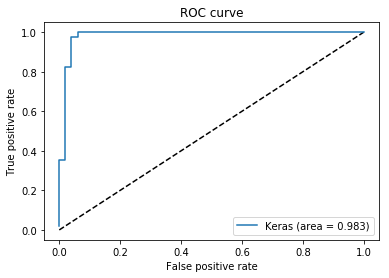

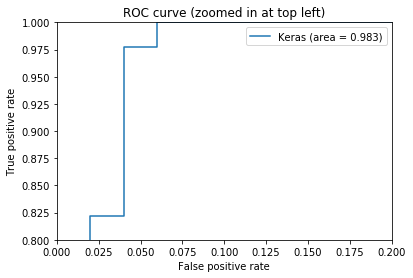

In [54]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

dict_keys(['val_loss', 'val_binary_accuracy', 'val_binary_crossentropy', 'val_true_positives', 'val_false_negatives', 'val_sensitivity', 'val_specificity', 'loss', 'binary_accuracy', 'binary_crossentropy', 'true_positives', 'false_negatives', 'sensitivity', 'specificity'])


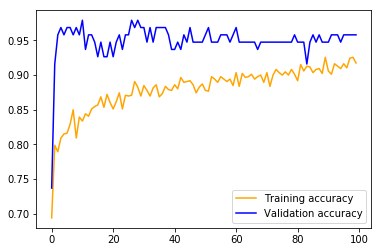

In [55]:
# import matplotlib library, and plot training cuve
import matplotlib.pyplot as plt 
print(history.history.keys())
plt.figure()
plt.plot(history.history['binary_accuracy'], 'orange', label='Training accuracy') 
plt.plot(history.history['val_binary_accuracy'], 'blue', label='Validation accuracy') 
#plt.plot(history.history['loss'], 'red', label='Training loss') 
#plt.plot(history.history['val_loss'], 'green', label='Validation loss') 
plt.legend()
plt.show()